In [1]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import *
from tqdm.auto import tqdm
from torch import optim
import seaborn as sns
from torch import nn
import numpy as np
import torch
import timm
import cv2

/root/anaconda3/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/Cats'

In [3]:
args           = edict({})
args.bs        = 32
args.lr        = 1e-3
args.seed      = 99
args.device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.epochs    = 20
args.n_samples = 3

In [4]:
class CatsDataset(Dataset):

    def __init__(self, paths, dtype = 'train'):

        self.paths     = paths
        self.dtype     = dtype
        
        self.transform          = {}
        self.transform['train'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                        transforms.Resize((299, 299)),
                                        transforms.ToTensor()
                                    ])

        self.transform['test']  = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((299, 299)),
                                    transforms.ToTensor()
                                ])

    
    def show_distribution(self):

        labels = [path.split(SEP)[-2] for path in self.paths]
        lb_cnt = Counter(labels)

        plt.bar(lb_cnt.keys(), lb_cnt.values())
        for k, v in lb_cnt.items():

            plt.text(k, v, v,
                     ha = 'center', va = 'bottom')
    

    def show_samples(self, n_samples = args.n_samples):

        random_idx  = np.random.randint(0, len(self.paths), n_samples)
        _, axes     = plt.subplots(1, n_samples, figsize = ((7 * n_samples) + 3, 7))

        for ax, idx in zip(axes, random_idx):

            image   = self.imread(self.paths[idx])
            label   = get_label(self.paths[idx])

            ax.imshow(image)
            ax.set_title(label)
            ax.axis(False)


    def imread(self, path, chn = 3):

        image = cv2.imread(path)
        flag  = cv2.COLOR_BGR2RGB if chn == 3 else cv2.COLOR_BGR2GRAY

        return cv2.cvtColor(image, flag)
        
    
    
    def __len__(self):

        return len(self.paths)


    def __getitem__(self, idx):

        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = get_label(self.paths[idx])

        if self.transform:
            image = self.transform[self.dtype](image)

        label = torch.tensor(lb2idx[label])

        return image, label


class BleedNet(nn.Module):

    def __init__(self, n_classes):

        super(BleedNet, self).__init__()
        self.n_classes = n_classes

        self.base_model    = timm.create_model('resnet152d', pretrained = True)
        self.base_model.fc = nn.Sequential(
                                nn.Linear(self.base_model.fc.in_features, 512),
                                nn.Dropout(0.4),
                                nn.ReLU(),

                                nn.Linear(512, 128),
                                nn.Dropout(0.4),
                                nn.ReLU(),

                                nn.Linear(128, 32),
                                nn.Dropout(0.3),
                                nn.ReLU(),

                                nn.Linear(32, n_classes)
                            )


    def forward(self, x):

        x    = self.base_model(x)
        return x



def train(model, loader, optim):

    losses, accuracy = 0, 0
    model.train()

    for image, label in (pbar := tqdm(loader)):

        pbar.set_description('[TRAIN]   ')
        optimizer.zero_grad()
        
        image   = image.to(args.device)
        label   = label.to(args.device)

        outputs = model(image)
        loss    = loss_func(outputs, label)

        loss.backward()
        optimizer.step()
        
        pred      = outputs.max(1, keepdim = True)[1]
        accuracy += pred.eq(label.view_as(pred)).sum().item()
        losses   += loss.item()

    accuracy /= len(loader.dataset)
    losses   /= len(loader.dataset)

    return accuracy, losses


def evaluate(model, loader):

    losses, accuracy = 0, 0
    
    model.eval()
    with torch.no_grad():
        for image, label in (pbar := tqdm(loader)):

            pbar.set_description('[EVALUATE]')
            image = image.to(args.device)
            label = label.to(args.device)

            outputs = model(image)
            loss    = loss_func(outputs, label)
            pred    = outputs.max(1, keepdim = True)[1]

            accuracy += pred.eq(label.view_as(pred)).sum().item()
            losses   += loss.item()

    accuracy /= len(loader.dataset)
    losses   /= len(loader.dataset)

    return accuracy, losses


get_label = lambda path: path.split(SEP)[-2]

In [5]:
image_paths               = sorted(list_images(DATA_PATH))
labels                    = [get_label(path) for path in image_paths]

lb2idx                    = {lb  : idx for idx,  lb in enumerate(set(labels))}
idx2lb                    = {idx : lb  for lb , idx in lb2idx.items()}

train_paths, valid_paths  = train_test_split(image_paths   , test_size    =        0.2, stratify = labels,
                                             shuffle = True, random_state =  args.seed)
train_paths, test_paths   = train_test_split(train_paths   , test_size    =       0.25, stratify = [get_label(path) for path in train_paths],
                                             shuffle = True, random_state =  args.seed)

In [6]:
train_dataset = CatsDataset(train_paths)
test_dataset  = CatsDataset(test_paths   , dtype = 'test')
valid_dataset = CatsDataset(valid_paths  , dtype = 'test')

train_loader  = DataLoader(train_dataset, shuffle = True , batch_size = args.bs)
test_loader   = DataLoader(test_dataset , shuffle = False, batch_size = args.bs)
valid_loader  = DataLoader(valid_dataset, shuffle = False, batch_size = 1)

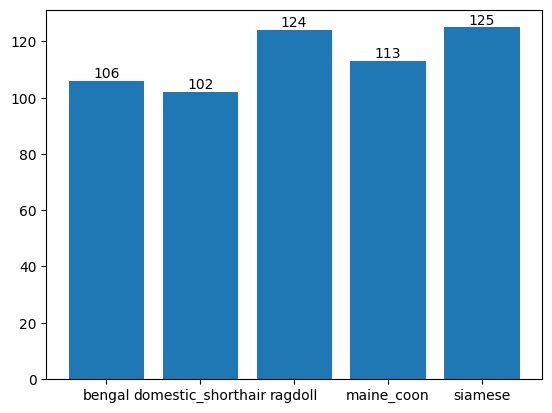

In [7]:
train_dataset.show_distribution()

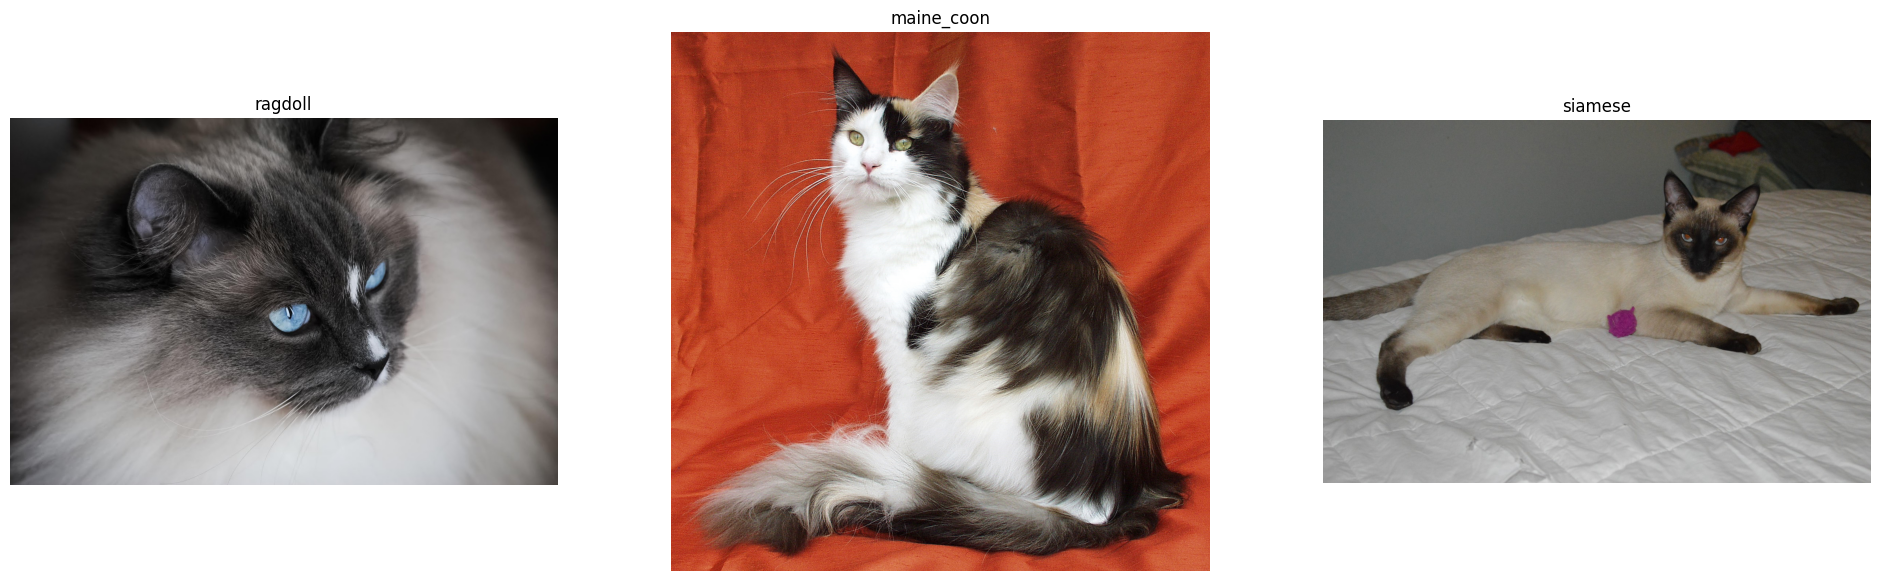

In [8]:
train_dataset.show_samples()

In [9]:
model     = BleedNet(len(idx2lb)).to(args.device)
optimizer = optim.Adam(model.parameters(), lr = args.lr)
loss_func = nn.CrossEntropyLoss()

In [10]:
for epoch in range(1, args.epochs + 1):

    print(f'[{epoch} / {args.epochs}]')
    tr_acc, tr_loss = train(model   , train_loader, optimizer)
    te_acc, te_loss = evaluate(model,  test_loader)

    print(f'[TRAIN] accuracy : {tr_acc * 100:.3f} %, loss : {tr_loss:.3f}')
    print(f'[TEST]  accuracy : {te_acc * 100:.3f} %, loss : {te_loss:.3f}\n')

[1 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


[TRAIN] accuracy : 31.228 %, loss : 0.048
[TEST]  accuracy : 39.474 %, loss : 0.055

[2 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.05s/it]


[TRAIN] accuracy : 48.070 %, loss : 0.039
[TEST]  accuracy : 57.895 %, loss : 0.045

[3 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


[TRAIN] accuracy : 60.702 %, loss : 0.036
[TEST]  accuracy : 52.105 %, loss : 0.045

[4 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]


[TRAIN] accuracy : 71.404 %, loss : 0.028
[TEST]  accuracy : 68.421 %, loss : 0.049

[5 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.17s/it]


[TRAIN] accuracy : 72.105 %, loss : 0.026
[TEST]  accuracy : 60.000 %, loss : 0.039

[6 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]


[TRAIN] accuracy : 78.947 %, loss : 0.019
[TEST]  accuracy : 72.632 %, loss : 0.033

[7 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


[TRAIN] accuracy : 73.509 %, loss : 0.026
[TEST]  accuracy : 51.053 %, loss : 0.044

[8 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


[TRAIN] accuracy : 81.404 %, loss : 0.020
[TEST]  accuracy : 76.842 %, loss : 0.024

[9 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


[TRAIN] accuracy : 80.877 %, loss : 0.020
[TEST]  accuracy : 64.211 %, loss : 0.034

[10 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


[TRAIN] accuracy : 87.193 %, loss : 0.014
[TEST]  accuracy : 75.263 %, loss : 0.029

[11 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


[TRAIN] accuracy : 87.895 %, loss : 0.014
[TEST]  accuracy : 66.316 %, loss : 0.038

[12 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]


[TRAIN] accuracy : 86.667 %, loss : 0.015
[TEST]  accuracy : 62.632 %, loss : 0.041

[13 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


[TRAIN] accuracy : 91.228 %, loss : 0.011
[TEST]  accuracy : 81.053 %, loss : 0.019

[14 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]


[TRAIN] accuracy : 91.228 %, loss : 0.011
[TEST]  accuracy : 64.211 %, loss : 0.046

[15 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


[TRAIN] accuracy : 87.719 %, loss : 0.012
[TEST]  accuracy : 79.474 %, loss : 0.021

[16 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]


[TRAIN] accuracy : 90.526 %, loss : 0.010
[TEST]  accuracy : 75.263 %, loss : 0.032

[17 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


[TRAIN] accuracy : 95.088 %, loss : 0.006
[TEST]  accuracy : 75.263 %, loss : 0.037

[18 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


[TRAIN] accuracy : 93.509 %, loss : 0.008
[TEST]  accuracy : 69.474 %, loss : 0.046

[19 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


[TRAIN] accuracy : 93.158 %, loss : 0.011
[TEST]  accuracy : 67.895 %, loss : 0.039

[20 / 20]


[EVALUATE]: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]

[TRAIN] accuracy : 92.632 %, loss : 0.007
[TEST]  accuracy : 80.526 %, loss : 0.021

